In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from keras import Input
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import models, layers
import sys,os,math,pathlib
from tensorflow.python.client import device_lib
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add

In [2]:
new_data_dir='C:/Users/jaehee/Desktop/graduation_project/voice_data_files/2021_9/09_11/test_class(bad+aug(bad))_32'
batch_size = 32
split_percent=0.3
rand_seed=123
shuffle_num=1000

In [3]:
data_dir = pathlib.Path(new_data_dir)
image_list = list(data_dir.glob('*/*.png'))
image_size = Image.open(image_list[0]).size
img_width=image_size[0]
img_height=image_size[1]

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=split_percent,
    subset="training",
    seed=rand_seed,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 224 files belonging to 7 classes.
Using 157 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=split_percent ,
    subset="validation",
    seed=rand_seed,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 224 files belonging to 7 classes.
Using 67 files for validation.


In [6]:
class_names = train_ds.class_names
num_classes = len(class_names)
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(shuffle_num).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

In [7]:
load_model_name="aug(bad)+origin(bad)(batch=32).h5"
load_model_date="09_08"
load_model_dir='C:/Users/jaehee/Desktop/jupyter_proj/model'

test_h5 = load_model(load_model_dir+'/'+load_model_date+'/'+load_model_name)
test_h5.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 200, 260, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 206, 266, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 130, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 130, 64) 256         conv2d[0][0]                     
_______________________________________________________________________________________

In [8]:
for layer in test_h5.layers[:-2]:
    layer.trainable = False
test_h5.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 200, 260, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 206, 266, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 130, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 130, 64) 256         conv2d[0][0]                     
_______________________________________________________________________________________

In [9]:
output_layer = test_h5.layers[-1]
output_layer.output.shape

TensorShape([None, 7])

In [10]:
transfer_model = Model(test_h5.input, output_layer(test_h5.layers[-2].output))
transfer_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 200, 260, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 206, 266, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 130, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 130, 64) 256         conv2d[0][0]                     
______________________________________________________________________________________________

In [11]:
transfer_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
transfer_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 200, 260, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 206, 266, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 130, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 130, 64) 256         conv2d[0][0]                     
______________________________________________________________________________________________

In [12]:
EPOCHS=200
history = transfer_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
)

Epoch 1/200
5/5 [==============================] - 7s 789ms/step - loss: 45.6652 - accuracy: 0.1406 - val_loss: 33.7962 - val_accuracy: 0.1493
Epoch 2/200
5/5 [==============================] - 1s 178ms/step - loss: 43.4979 - accuracy: 0.1186 - val_loss: 32.5910 - val_accuracy: 0.1642
Epoch 3/200
5/5 [==============================] - 1s 187ms/step - loss: 42.4564 - accuracy: 0.1176 - val_loss: 31.5757 - val_accuracy: 0.1642
Epoch 4/200
5/5 [==============================] - 1s 178ms/step - loss: 36.6242 - accuracy: 0.1896 - val_loss: 30.6551 - val_accuracy: 0.1642
Epoch 5/200
5/5 [==============================] - 1s 180ms/step - loss: 35.2079 - accuracy: 0.1983 - val_loss: 29.8053 - val_accuracy: 0.1791
Epoch 6/200
5/5 [==============================] - 1s 179ms/step - loss: 39.6794 - accuracy: 0.1184 - val_loss: 28.9275 - val_accuracy: 0.1642
Epoch 7/200
5/5 [==============================] - 1s 183ms/step - loss: 37.8844 - accuracy: 0.1476 - val_loss: 28.1145 - val_accuracy: 0.1642

5/5 [==============================] - 1s 174ms/step - loss: 2.2494 - accuracy: 0.6525 - val_loss: 2.2569 - val_accuracy: 0.6269
Epoch 59/200
5/5 [==============================] - 1s 184ms/step - loss: 1.9967 - accuracy: 0.6430 - val_loss: 2.1663 - val_accuracy: 0.6418
Epoch 60/200
5/5 [==============================] - 1s 175ms/step - loss: 2.0549 - accuracy: 0.6749 - val_loss: 2.0847 - val_accuracy: 0.6418
Epoch 61/200
5/5 [==============================] - 1s 179ms/step - loss: 1.9076 - accuracy: 0.6625 - val_loss: 1.9684 - val_accuracy: 0.6716
Epoch 62/200
5/5 [==============================] - 1s 176ms/step - loss: 1.8320 - accuracy: 0.7005 - val_loss: 1.8828 - val_accuracy: 0.6866
Epoch 63/200
5/5 [==============================] - 1s 177ms/step - loss: 1.6773 - accuracy: 0.7092 - val_loss: 1.8056 - val_accuracy: 0.6866
Epoch 64/200
5/5 [==============================] - 1s 177ms/step - loss: 1.5184 - accuracy: 0.7024 - val_loss: 1.7037 - val_accuracy: 0.6866
Epoch 65/200
5/5 [=

Epoch 116/200
5/5 [==============================] - 1s 177ms/step - loss: 0.1785 - accuracy: 0.9313 - val_loss: 0.3194 - val_accuracy: 0.8955
Epoch 117/200
5/5 [==============================] - 1s 177ms/step - loss: 0.2368 - accuracy: 0.9288 - val_loss: 0.3111 - val_accuracy: 0.8955
Epoch 118/200
5/5 [==============================] - 1s 174ms/step - loss: 0.2461 - accuracy: 0.9046 - val_loss: 0.2982 - val_accuracy: 0.8955
Epoch 119/200
5/5 [==============================] - 1s 179ms/step - loss: 0.2944 - accuracy: 0.9131 - val_loss: 0.2891 - val_accuracy: 0.8955
Epoch 120/200
5/5 [==============================] - 1s 176ms/step - loss: 0.2163 - accuracy: 0.9256 - val_loss: 0.2832 - val_accuracy: 0.8955
Epoch 121/200
5/5 [==============================] - 1s 177ms/step - loss: 0.1974 - accuracy: 0.9282 - val_loss: 0.2828 - val_accuracy: 0.8955
Epoch 122/200
5/5 [==============================] - 1s 179ms/step - loss: 0.1860 - accuracy: 0.9211 - val_loss: 0.2756 - val_accuracy: 0.8955

5/5 [==============================] - 1s 177ms/step - loss: 0.0454 - accuracy: 0.9845 - val_loss: 0.1172 - val_accuracy: 0.9254
Epoch 174/200
5/5 [==============================] - 1s 179ms/step - loss: 0.0356 - accuracy: 0.9948 - val_loss: 0.1157 - val_accuracy: 0.9254
Epoch 175/200
5/5 [==============================] - 1s 175ms/step - loss: 0.0321 - accuracy: 0.9965 - val_loss: 0.1146 - val_accuracy: 0.9254
Epoch 176/200
5/5 [==============================] - 1s 176ms/step - loss: 0.0288 - accuracy: 0.9979 - val_loss: 0.1138 - val_accuracy: 0.9254
Epoch 177/200
5/5 [==============================] - 1s 176ms/step - loss: 0.0240 - accuracy: 0.9979 - val_loss: 0.1129 - val_accuracy: 0.9254
Epoch 178/200
5/5 [==============================] - 1s 177ms/step - loss: 0.0275 - accuracy: 0.9979 - val_loss: 0.1115 - val_accuracy: 0.9254
Epoch 179/200
5/5 [==============================] - 1s 181ms/step - loss: 0.0329 - accuracy: 0.9948 - val_loss: 0.1095 - val_accuracy: 0.9254
Epoch 180/200

In [13]:
from keras.models import load_model
save_model_date="09_11"
save_model_name="transfer(bad(per2)+aug_bad(all_per30)layers-2)"
save_model_dir='C:/Users/jaehee/Desktop/jupyter_proj/model/'
#h5 타입
transfer_model.save(save_model_dir+'/'+save_model_date+'/'+save_model_name+'.h5')
#tf 타입
transfer_model.save(save_model_dir+'/'+save_model_date+'/'+save_model_name, save_format='tf')

INFO:tensorflow:Assets written to: C:/Users/jaehee/Desktop/jupyter_proj/model//09_11/transfer(bad(per2)+aug_bad(all_per30)layers-2)\assets


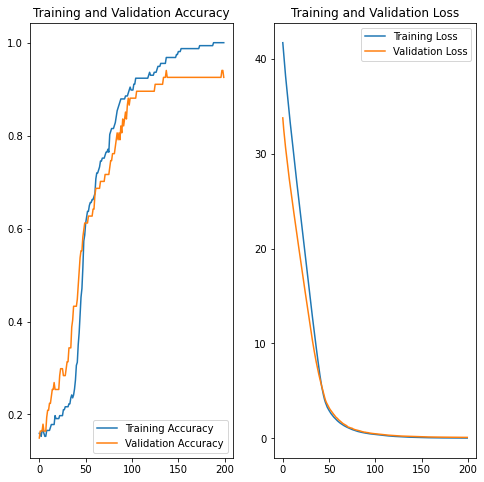

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy') 
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig(save_model_dir+'/'+save_model_date+'/graph/'+save_model_name+".png",bbox_inches='tight',
                pad_inches=0)

In [15]:
import sys
from keras.preprocessing import image

pred_data_dir='C:/Users/jaehee/Desktop/graduation_project/voice_data_files/2021_9/09_11/val_class(per3)/bad'

#file_name_list=['good_morning_bad.png','youtube_bad.png','sangho_bad.png','music_bad.png','traffic_bad.png','today_bad.png','tomorrow_bad.png']
file_name_list=['good_morning_bad','youtube_bad','sangho_bad','music_bad','traffic_bad','today_bad','tomorrow_bad']
#file_name_list=['good_morning_good','youtube_good','sangho_good','music_good','traffic_good','today_good','tomorrow_good']
class_name_list=['good_morning_bad','youtube_bad','sangho_bad','music_bad','traffic_bad','today_bad','tomorrow_bad']
#class_name_list=['good_morning_good','youtube_good','sangho_good','music_good','traffic_good','today_good','tomorrow_good']
#class_name_list=['good_morning','youtube','sangho','music','traffic','today','tomorrow']
txt_name = 'pred_text('+save_model_name+').txt'
sys.stdout = open(save_model_dir+'/'+save_model_date+'/'+txt_name,'w')
for t in range(len(file_name_list)):   
    for j in range(1,4):
        image_path = pred_data_dir+'/'+class_name_list[t]+"/"+file_name_list[t]+' ('+str(j)+').png'
        img = image.load_img(image_path, target_size=(img_height, img_width))
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch
        #print(img_array)
        predictions = transfer_model.predict(img_array)
        #print(predictions)
        score = tf.nn.softmax(predictions[0])
        #print(score)
        print("{} ----> {} 클래스".format(file_name_list[t],class_names[np.argmax(score)], 100 * np.max(score)))